## Start and prepare EC2 instances

In this notebook instruction are provided to start three EC2 instanes. On all three the same packages have to be installed. For this we use a the `userdata` section.

Go to the EC2 in the management console. 

Go to instances and click `Launch instances`

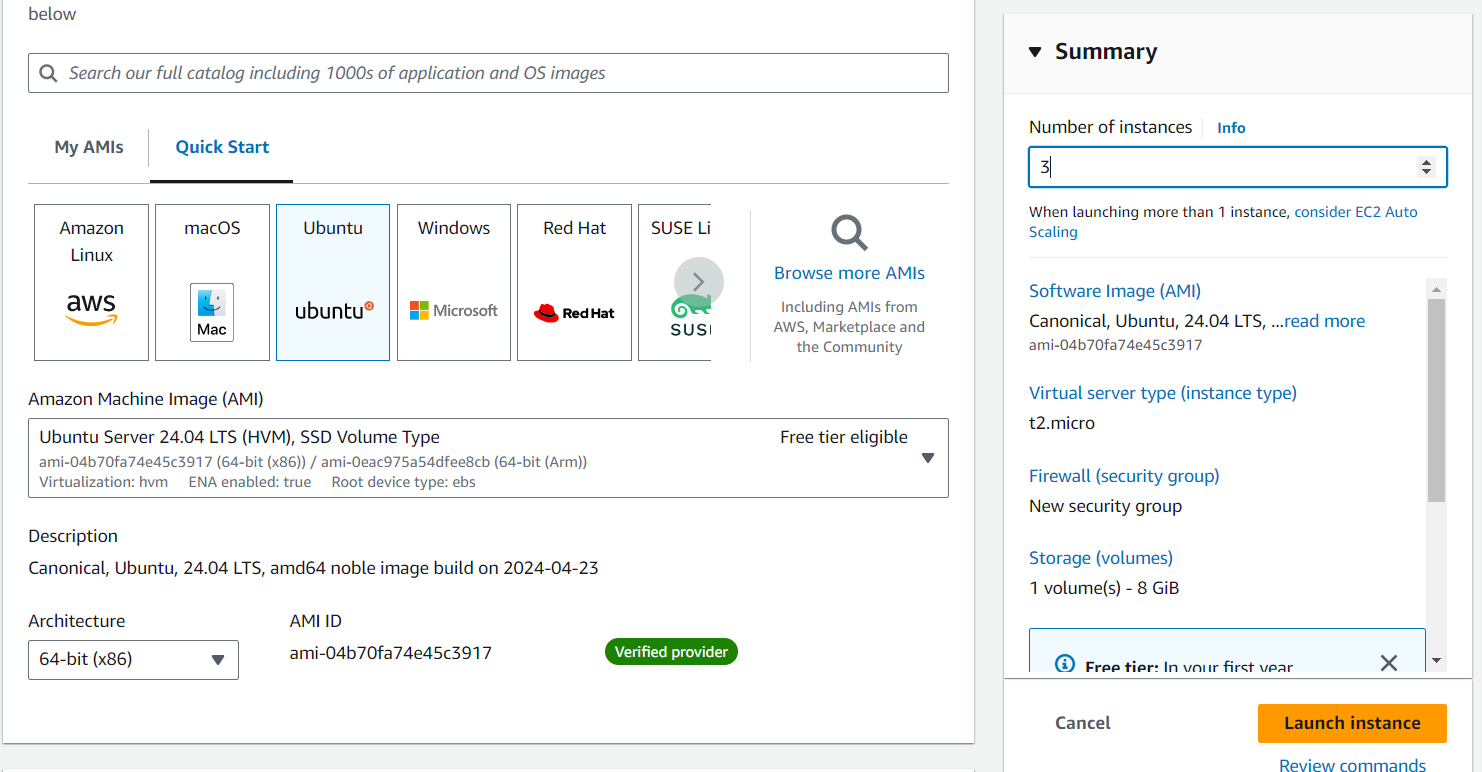

go down and make sure you select or create a `Key pair`

go down and under `Advanced details` go to the user data (at the bottom)

```
#!/bin/bash
sudo apt update
sudo apt upgrade -y
sudo apt install python3-pip -y
sudo apt install python3-distributed -y
sudo  apt install python3.12-venv -y

python3 -m venv .venv
source .venv/bin/activate
python3 -m pip install "dask[complete]"
```

Launche the instances

Give the first instance the name `dask-scheduler` and the other two instances the name `dask-worker`

the user data instruction have been tested on an EC2 instance and they all worked. 

Due to the userdata starting the instances might take a bit longer.

## Opening port in the security group

Since the instances are all started at the same time they are all related to the same security group.

The security group can be found by selecting one of the instances and then go the the security tab.

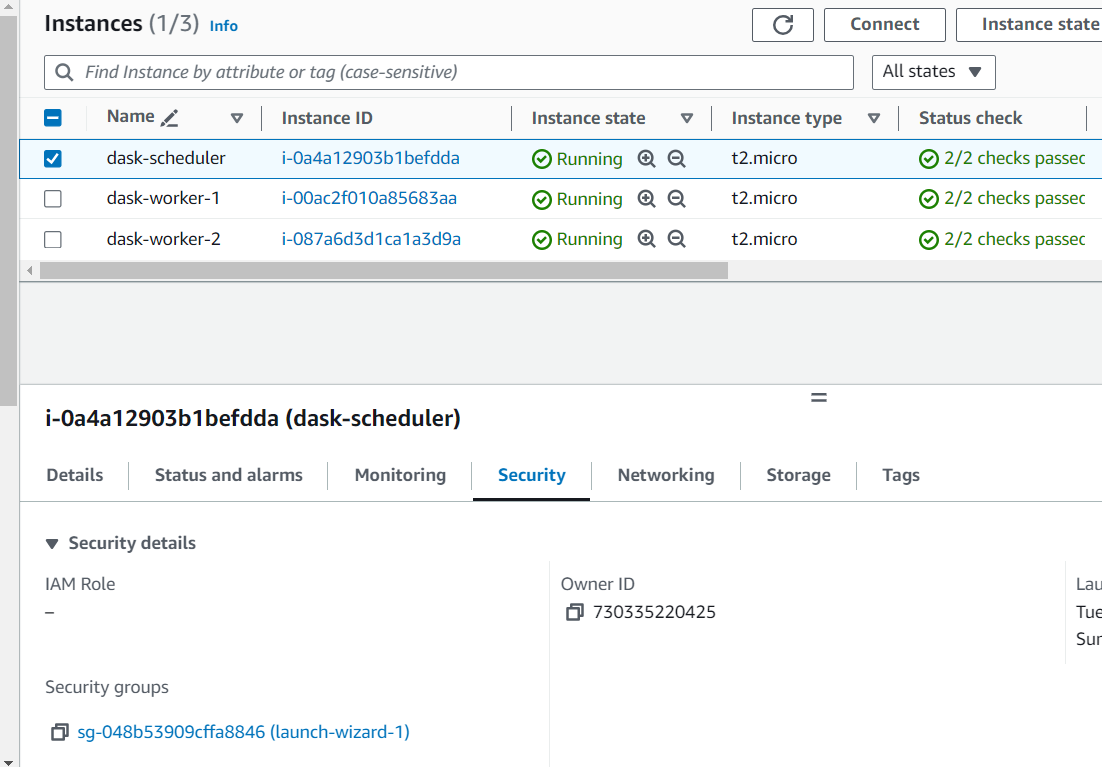

open the security group and go to `Edit Inbound Rules` under `Inbound Rules` then `Add Rule`. Add some rules and make sure it looks like in the image below

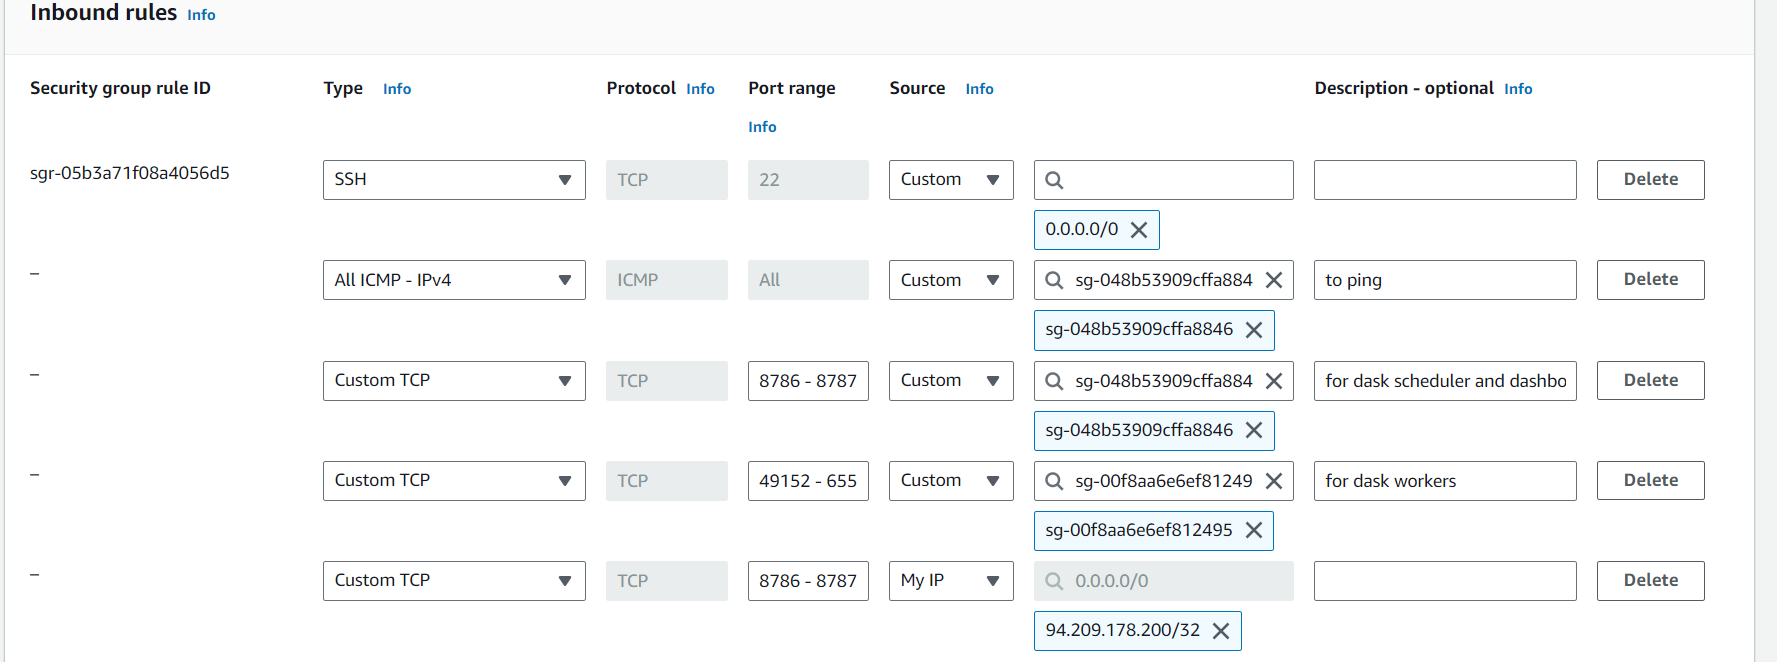

click save rules

log into the dask scheduler instance and try to ping the workers usine

`ping <private-ip-adress`

On my machine both pinged correctly.

## Setting up cluster with the CLI

log into each instance using for example Putty

in the terminal of the scheduler instance type:

`dask scheduler` 

this should among other show the something like below

```
2024-06-25 14:53:43,235 - distributed.scheduler - INFO -   Scheduler at:  tcp://172.31.21.203:8786
2024-06-25 14:53:43,235 - distributed.scheduler - INFO -   dashboard at:  http://172.31.21.203:8787/status
```

on each worker now execute

`dask worker tcp://172.31.21.203:8786`

this should return among others output that contains

```
2024-06-25 14:59:22,385 - distributed.nanny - INFO -         Start Nanny at: 'tcp://172.31.24.71:33373'
2024-06-25 14:59:23,015 - distributed.worker - INFO -       Start worker at:   tcp://172.31.24.71:46673
2024-06-25 14:59:23,016 - distributed.worker - INFO -          Listening to:   tcp://172.31.24.71:46673
2024-06-25 14:59:23,016 - distributed.worker - INFO -          dashboard at:         172.31.24.71:35887
2024-06-25 14:59:23,016 - distributed.worker - INFO - Waiting to connect to:   tcp://172.31.21.203:8786
2024-06-25 14:59:23,016 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,017 - distributed.worker - INFO -               Threads:                          1
2024-06-25 14:59:23,017 - distributed.worker - INFO -                Memory:                   0.94 GiB
2024-06-25 14:59:23,017 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-9tb94gip
2024-06-25 14:59:23,017 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,277 - distributed.worker - INFO - Starting Worker plugin shuffle
2024-06-25 14:59:23,278 - distributed.worker - INFO -         Registered to:   tcp://172.31.21.203:8786
2024-06-25 14:59:23,278 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,279 - distributed.core - INFO - Starting established connection to tcp://172.31.21.203:8786
```



now the cluster is ready with one scheduler and 2 workers

Now we can see the daskboard using the **public ip** (not the private) 

`http://34.229.148.157:8787/status`

on this tab `workers`

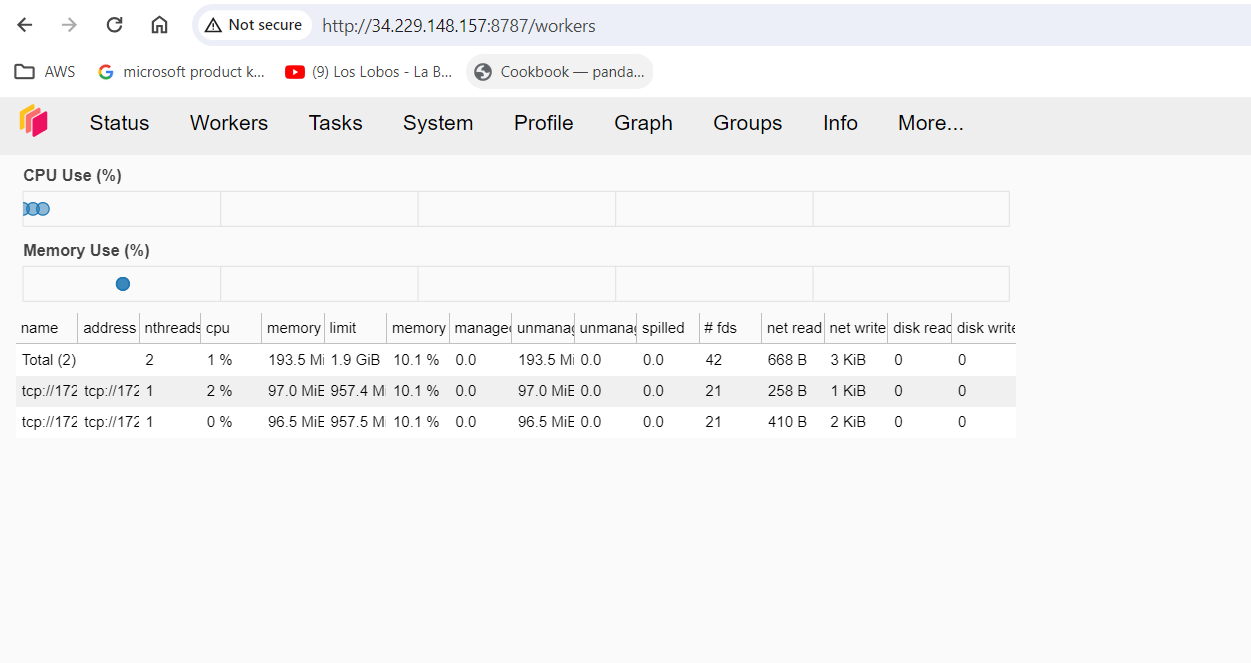

# TODO

The user data is really installed in the root while we log in as ubuntu in the directory /home/ubuntu we need to do cd .. twice to be in the root and there we can find the .venv
start this (from user data) and then look at the url above

# Run jupyter 

To run jupyter on an EC2 instance and connect to it from your local machine, install jupyter on the server, open up port 8080 (or another) and execute the following command on the server. 

` jupyter notebook --no-browser --port=8080 --ip=0.0.0.0 --allow-root`

The output will something like

` http://127.0.0.1:8080/tree?token=ea112db195c9c58c4a2043aac3b52b3897fab80dbf546e12`

replace the `127.0.0.1` with the external IP adress of the server and execute the whole expression in your local browser. Now you should be connected to the server notebook.